In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import math
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

In [17]:
#Function to convert GPS time to milliseconds
#The base time is the RTC time in milliseconds that corresponds with the first GPS time stamp
def timeToMillis(time, RTC_millis):
    sec = np.zeros(time.size)
    sec = sec.astype(int)
    minutes = np.zeros(time.size)
    minutes = minutes.astype(int)
    hours = np.zeros(time.size)
    hours = hours.astype(int)
    for i in range(0, time.size):
        sec[i] = time[i]%100
    for i in range(0, time.size):
        minutes[i] = (time[i]%10000 - time[i]%100)/100
    for i in range(0, time.size):
        hours[i] = (time[i] - time[i]%10000)/10000

    GPS_millis = np.zeros(time.size)
    GPS_millis = GPS_millis.astype(int)
    GPS_millis[0] = RTC_millis[0]
    for i in range (1, time.size):
        if (sec[i] > sec[i - 1]):
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1])*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (60 + minutes[i] - minutes[i - 1])*60*1000            
        else:
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1] - 1)*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (59 + minutes[i] - minutes[i - 1])*60*1000            
    return GPS_millis


#Function to convert time in milliseconds to digital time 
#Used to convert both GPS time in milliseconds and RTC time in milliseconds to digital time 
#The base time is taken as the first GPS time stamp
def millisToTime(millis, time):
    mil = millis/1000
    time_temp = np.zeros(time.size)
    hours = np.zeros(time_temp.size)
    minutes = np.zeros(time_temp.size)
    seconds = np.zeros(time_temp.size)
    time_temp[0] = time[0]
    for i in range (1, time.size):
        seconds[i] = time_temp[i - 1]%100 + (mil[i] - mil[i - 1])
        if (seconds[i] > 60):
            temp_minutes = 0
            while (seconds[i] >= 60):
                temp_minutes += 100
                seconds[i] = seconds[i] - 60
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + temp_minutes
        elif (seconds[i] == 60):
            seconds[i] = 0
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + 100
        else:
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100)
        if (minutes[i] > 5900):
            minutes[i] = 6000 - minutes[i]
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000) + 10000
        else:
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000)
        if (hours[i] > 230000):
            hours[i] = 240000 - hours[i]
        time_temp[i] = hours[i] + minutes[i] + seconds[i]

    #Split time with colons
    output_time = [0 for i in range(time_temp.size)]
    hours_temp = np.zeros(time_temp.size)
    minutes_temp = np.zeros(time_temp.size)
    seconds_temp = np.zeros(time_temp.size)
    for i in range (0, time_temp.size):
        hours_temp[i] = int((time_temp[i] - time_temp[i]%10000)/10000)
        minutes_temp[i] = int((time_temp[i]%10000 - time_temp[i]%100)/100)
        seconds_temp[i] = time_temp[i]%100
        if (seconds_temp[i] < 10):
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
            else:
                output_time[i] = "%d:%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
        else:
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])  
            else:
                output_time[i] = "%d:%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
    return output_time 

#Split data into training and testing sets (0.8/0.2)
def dataSplit(x_millis, y_millis):
    x_train, x_test, y_train, y_test = train_test_split(x_millis, y_millis, test_size=0.2, random_state=1)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 1)
    return x_train.reshape(-1,1), y_train.reshape(-1,1), x_test.reshape(-1,1), y_test.reshape(-1,1), x_val.reshape(-1,1), y_val.reshape(-1,1)


#Metrics for regression analysis
def RMSE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = (y[i] - predict[i])**2
    return np.sqrt((np.sum(c))/len(c))

def MAE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = abs(y[i] - predict[i])
    return (np.sum(c))/len(c)

#Metrics related to clock AccOffset 
def plotDrift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    t = np.linspace(50000, len(GPS_millis[50000:len(GPS_millis)]), len(GPS_millis[50000:len(GPS_millis)]))
    plt.plot(t, Drift[50000:len(GPS_millis)])
    plt.title('Frequency of clock drift of Teensy internal RTC (ppm)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Drift (ppm)')
    plt.show()

def plotOffset(GPS_millis, RTC_millis):
    offset = np.zeros(GPS_millis.size)
    offsetsum = 0
    for i in range(0, GPS_millis.size):
        offset[i] = (GPS_millis[i] - offsetsum - RTC_millis[i])
        offsetsum = np.sum(offset)
    t = np.linspace(0, len(GPS_millis), len(GPS_millis))
    plt.plot(t, offset)
    plt.title('Clock offset of internal Teensy RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Clock offset (ms)')
    plt.show()
    

def plotAccOffset(GPS_millis, RTC_millis):
    AccOffset = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        AccOffset[i] = (GPS_millis[i] - RTC_millis[i])
    t = np.linspace(0, len(GPS_millis), len(GPS_millis))
    plt.plot(t, AccOffset)
    plt.title('Accumulated offset of Teensy internal RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Accumulated offset (ms)')
    plt.show()
    
def AccOffset(GPS_millis, RTC_millis):
    d = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        d[i] = (GPS_millis[i] - RTC_millis[i])
    return d

def Drift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    return Drift

def convertToCycles(array):
    a = np.zeros(array.size)
    for i in range(0, array.size):
        a[i] = (array[i]/1000)*32768
    return a

#dataframe to summarise linear regression metrics
def RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, model):
    predict1 = model.predict(x1_train)
    r1 =  model.score(x1_train, y1_train)
    rmse1 = RMSE(predict1, y1_train)
    mae1 =  MAE(predict1, y1_train)
    
    predict2 = model.predict(x1_test)
    r2 = model.score(x1_test, y1_test)
    rmse2 = RMSE(predict2, y1_test)
    mae2 = MAE(predict2, y1_test)
    
    predict3 = model.predict(x1_val)
    r3 = model.score(x1_val, y1_val)
    rmse3 = RMSE(predict3, y1_val)
    mae3 = MAE(predict3, y1_val)
    
    d = {'Index Title': ['Training', 'Validation', 'Test'],'R': [r1, r3, r2], 'RMSE' : [rmse1, rmse3, rmse2], 'MAE' :[mae1, mae3, mae2]}
    df = pd.DataFrame(d).set_index('Index Title')
    return display(df)


#Data Frames to summarise metrics for testing sets and display synchronised time
def synch(input_vector, RTC_millis, GPS_millis, model, time, drift):
    millis_predict = model.predict(input_vector)
    #Convert drift prediction to synchronised time by adding the drift to RTC time in milliseconds
    for i in range (0, millis_predict.size):
        millis_predict[i] = RTC_millis[i] + millis_predict[i]
    millis_predict = (np.reshape(millis_predict, len(millis_predict))).astype(int)
    rmse =  RMSE(millis_predict, GPS_millis)
    mae = MAE(millis_predict, GPS_millis)
    
    d = {'RMSE' : [rmse], 'MAE' :[mae]}
    d = pd.DataFrame(d)
    display(d)
    df = pd.DataFrame({'GPS Time (ms)': GPS_millis, 'RTC Time (ms)': RTC_millis, 
                         'Synch Time (ms)' : millis_predict, 'GPS Time': millisToTime(GPS_millis, time),
                            'RTC Time':millisToTime(RTC_millis, time), 'Synch Time' : millisToTime(millis_predict, time)})
    display(df)

In [18]:
#Reading data from training run of sensor 1
with open('GPT2.TXT', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(",") for line in stripped if line)
    with open('GPT2.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('GPS/RTC', 'Time', 'Day', 'Month', 'Year', 'Millis', 'Temp', 'Offset', 'Number'))
        writer.writerows(lines)
        
data1 = pd.read_csv("GPT2.csv")
data_arr1 = np.array(data1)
time1 = data_arr1[0:,1]
RTC_millis1 = data_arr1[0:,5]
temp1 = data_arr1[0:,6]
offset1 = data_arr1[0:,7]
num1 = data_arr1[0:,8]

#Cleaning data
for i in range(0, 131063):
    RTC_millis1[i] = (RTC_millis1[i]- 9*(32768) - 12343)/32768
RTC_millis1[131063] = 32768  
for i in range(131064, RTC_millis1.size):
    RTC_millis1[i] = RTC_millis1[i] + 6662
for i in range(131063, RTC_millis1.size):
    RTC_millis1[i] = RTC_millis1[i]/32768 + RTC_millis1[131062]
cycles = np.zeros(RTC_millis1.size)
for i in range(RTC_millis1.size):
    cycles[i] = RTC_millis1[i]*32768
for i in range(RTC_millis1.size):
    RTC_millis1[i] = RTC_millis1[i]*1000


In [19]:
#Determining the GPS milliseconds since start-up for all three sensors
GPS_millis1 = timeToMillis(time1, RTC_millis1)

#Determining the AccOffset of all three sensors
AccOffset1 = AccOffset(GPS_millis1, RTC_millis1)

#Creating input vector from RTC milliseconds and temperature arrays
x1 = pd.DataFrame({'RTC_millis1': RTC_millis1, 'temp1': temp1, 'AccOffset1': AccOffset1})

X1 = pd.concat([x1["RTC_millis1"],x1["temp1"]], axis = 1)

#Splitting the training and testing data 
train1_rand = x1.sample(frac=0.8, random_state=1)
test1 = x1.drop(train1_rand.index)
test1_rand = test1.sample(frac = 0.5, random_state = 1)
val1 = test1.drop(test1_rand.index)
val1_rand = val1.sample(frac = 0.5, random_state = 1)

x1_train = pd.concat([train1_rand["RTC_millis1"],train1_rand["temp1"]], axis = 1)
y1_train = pd.concat([train1_rand["AccOffset1"]], axis = 1)

x1_test = pd.concat([test1_rand["RTC_millis1"],test1_rand["temp1"]], axis = 1)
y1_test = pd.concat([test1_rand["AccOffset1"]], axis = 1)

x1_val = pd.concat([val1_rand["RTC_millis1"],val1_rand["temp1"]], axis = 1)
y1_val = pd.concat([val1_rand["AccOffset1"]], axis = 1)

In [15]:
#TensorFlow linear regression
normalizer1 = preprocessing.Normalization()
normalizer1.adapt(np.array(x1_train))

model3 = tf.keras.Sequential([
    normalizer1,
    layers.Dense(units=1)
])

model3.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history1 = model3.fit(
    np.array(x1_train).astype(float), np.array(y1_train).astype(float),
    epochs = 8,
    verbose = 1
    )

Train on 205880 samples
Epoch 1/8
205880/205880 [==============================] - 6s 30us/sample - loss: 260.5078
Epoch 2/8
205880/205880 [==============================] - 6s 29us/sample - loss: 4.9778
Epoch 3/8
205880/205880 [==============================] - 6s 30us/sample - loss: 4.9773
Epoch 4/8
205880/205880 [==============================] - 6s 29us/sample - loss: 4.9774
Epoch 5/8
205880/205880 [==============================] - 6s 29us/sample - loss: 4.9770
Epoch 6/8
205880/205880 [==============================] - 6s 29us/sample - loss: 4.97690s - loss: 4.
Epoch 7/8
205880/205880 [==============================] - 6s 29us/sample - loss: 4.9782
Epoch 8/8
205880/205880 [==============================] - 6s 29us/sample - loss: 4.9773


In [19]:
predict = model3.predict(np.array(x1_val).astype(float))
#predict = np.reshape((predict),len(predict))
print(MAE(predict, np.array(y1_val)))
print(RMSE(predict, np.array(y1_val)))

5.032869798484188
6.444982410609595


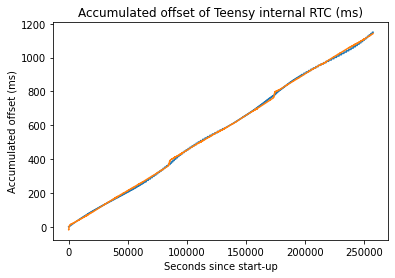

In [26]:
prediction = model3.predict(np.array(X1).astype(float))
t = np.linspace(0, len(GPS_millis1), len(GPS_millis1))
plt.plot(t, AccOffset1)
plt.plot(t, prediction)
plt.title('Accumulated offset of Teensy internal RTC (ms)')
plt.xlabel('Seconds since start-up')
plt.ylabel('Accumulated offset (ms)')
plt.show()

In [20]:
#Tensor flow neural network

normalizer1 = preprocessing.Normalization()
normalizer1.adapt(np.array(x1_train))

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

net2 = build_and_compile_model(normalizer1)

history2 = net2.fit(
    np.array(x1_train).astype(float), np.array(y1_train).astype(float),
    verbose=1, epochs=8)



Train on 205880 samples
Epoch 1/8
205880/205880 [==============================] - 8s 38us/sample - loss: 29.0952
Epoch 2/8
205880/205880 [==============================] - 8s 37us/sample - loss: 2.1068: 0s - loss:
Epoch 3/8
205880/205880 [==============================] - 7s 35us/sample - loss: 2.00650s - loss: 2
Epoch 4/8
205880/205880 [==============================] - 7s 35us/sample - loss: 1.93807s - 
Epoch 5/8
205880/205880 [==============================] - 7s 35us/sample - loss: 1.84433s - l
Epoch 6/8
205880/205880 [==============================] - 7s 35us/sample - loss: 1.74945s - loss: 1.796 - ETA: 5 - ETA:  - ETA: 3s  - ETA: 2s - loss: 1. - ETA: 2s  - - ETA: 0s - loss: 1.7 - ETA: 0s - 
Epoch 7/8
205880/205880 [==============================] - 8s 37us/sample - loss: 1.67842s - los  - ETA: 0s - loss: 1.678
Epoch 8/8
205880/205880 [==============================] - 8s 37us/sample - loss: 1.6508


In [21]:
predict2 = net2.predict(np.array(x1_val).astype(float))
#predict = np.reshape((predict),len(predict))
print(MAE(predict2, np.array(y1_val)))
print(RMSE(predict2, np.array(y1_val)))

1.609549293245334
2.1614254887086686


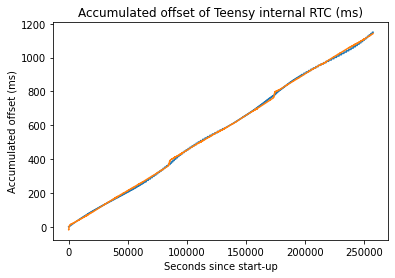

In [35]:
prediction2 = net2.predict(np.array(X1).astype(float))
t = np.linspace(0, len(GPS_millis1), len(GPS_millis1))
plt.plot(t, AccOffset1)
plt.plot(t, prediction)
plt.title('Accumulated offset of Teensy internal RTC (ms)')
plt.xlabel('Seconds since start-up')
plt.ylabel('Accumulated offset (ms)')
plt.show()

In [42]:
print("Time Synchronisation Results Using Neural Net")
synch(np.array(X1).astype(float), RTC_millis1, GPS_millis1, net2, time1, AccOffset1)
print("Time Synchronisation Results Using Linear Regression")
synch(np.array(X1).astype(float), RTC_millis1, GPS_millis1, model3, time1, AccOffset1)


Time Synchronisation Results Using Neural Net


,RMSE,MAE
0,5.424303,3.252201


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1000,999,19:17:16.000,19:17:16.000,19:17:16.000
1,2000,2000,1999,19:17:17.000,19:17:17.000,19:17:17.000
2,3000,3000,2999,19:17:18.000,19:17:18.000,19:17:18.000
3,4000,4000,3999,19:17:19.000,19:17:19.000,19:17:19.000
4,5000,5000,4999,19:17:20.000,19:17:20.000,19:17:20.000
...,...,...,...,...,...,...
257345,257346000,2.57345e+08,257345984,18:46:21.000,18:46:19.850,18:46:20.985
257346,257347000,2.57346e+08,257347008,18:46:22.000,18:46:20.850,18:46:22.009
257347,257348000,2.57347e+08,257347984,18:46:23.000,18:46:21.850,18:46:22.985
257348,257349000,2.57348e+08,257348992,18:46:24.000,18:46:22.850,18:46:23.993


Time Synchronisation Results Using Linear Regression


,RMSE,MAE
0,7.967172,6.013588


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1000,981,19:17:16.000,19:17:16.000,19:17:16.000
1,2000,2000,1981,19:17:17.000,19:17:17.000,19:17:17.000
2,3000,3000,2981,19:17:18.000,19:17:18.000,19:17:18.000
3,4000,4000,3981,19:17:19.000,19:17:19.000,19:17:19.000
4,5000,5000,4981,19:17:20.000,19:17:20.000,19:17:20.000
...,...,...,...,...,...,...
257345,257346000,2.57345e+08,257345984,18:46:21.000,18:46:19.850,18:46:21.003
257346,257347000,2.57346e+08,257346992,18:46:22.000,18:46:20.850,18:46:22.011
257347,257348000,2.57347e+08,257347984,18:46:23.000,18:46:21.850,18:46:23.003
257348,257349000,2.57348e+08,257348992,18:46:24.000,18:46:22.850,18:46:24.011


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X1.values.astype(float), i) for i in range(X1.astype(float).shape[1])]
vif["features"] = X1.columns
display(vif)

,VIF Factor,features
0,3.859429,RTC_millis1
1,3.859429,temp1


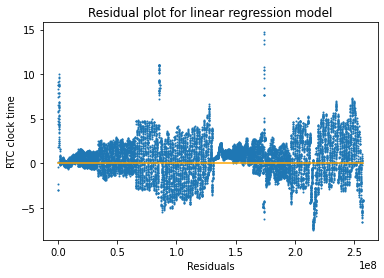

In [51]:
predict1 = net2.predict(np.array(x1_val).astype(float))
y1_val = np.array(y1_val)
x1_val = np.array(x1_val)
resid1 = np.zeros(y1_val.size)
for i in range(0, y1_val.size):
    resid1[i] = predict1[i] - y1_val[i]
#Residual plots
t = np.linspace(0,max(x1_val[0:,0]))
z = np.zeros(50)
plt.scatter(x1_val[0:,0], resid1, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for multiple linear regression model')
plt.xlabel('Prediction')
plt.ylabel('Residual in ms')
plt.show()